# Foreword
---

The following sections of python code are part of my professional thesis produced in context of the MSc in Big Data and Business analytics at ESCP Business School.

In this notebook we will be analyzing the dataset generated by the AMSS library (see the appropriate R document in the repository).

For further information explaining the context of this notebook, please refer to the corresponding professional thesis.

Best regards,
Alexander Ninua

2021

# 1. Preparation stage

## 1.1 Loading the libraries and preparing the data

In [2]:
#core libraries for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

#data preparation
from sklearn.model_selection import train_test_split

#model evaluation
from sklearn import metrics

#linear model
from sklearn.linear_model import LinearRegression

#xgboost model and the shap library for further interpretation
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree

import shap


In [3]:
#defiining the adstock formula

def adstocked_advertising(advertising, adstock_rate=0.1):
    
    """The adstock formula takes a pandas series as input and applies adstock as specified (0.1 by default)"""
        
    advertising = list(advertising)
    adstocked_advertising = []
    
    for i in range(len(advertising)):
        if i == 0: 
            adstocked_advertising.append(advertising[i])
        else:
            adstocked_advertising.append(advertising[i] + adstock_rate * adstocked_advertising[i-1])     
            
    return adstocked_advertising

In [4]:
#loading the AMSS output
#'o' in 'df_o' stands for 'original' in order to always keep the version of the unmodified AMSS output

df_o = pd.read_csv('Validated  - .7.0.AMSS_Data 2021-09-18.csv')

In [5]:
#checking the available columns

df_o.columns

Index(['Unnamed: 0', 'time.index', 'tv.volume', 'tv.spend', 'radio.volume',
       'radio.spend', 'press.volume', 'press.spend', 'total.spend',
       'brand.sales', 'competitor.sales', 'revenue', 'profit',
       'tv.budget.index', 'tv.budget', 'radio.budget.index', 'radio.budget',
       'press.budget.index', 'press.budget'],
      dtype='object')

In [6]:
#keeping the time index columns, the media explainer variables and revenue as the target variable

df = df_o[['time.index','tv.spend', 'radio.spend', 'press.spend', 'revenue']].copy()

In [7]:
#visualizing the media expenditure variables before applying adstock

media_cols = list(df.columns)
media_cols.remove('time.index')
media_cols.remove('revenue')

fig = px.line(df.reset_index(), x="time.index", y = media_cols, title='Review')

fig.show()

In [8]:
#Applying adstock for the media channels

df['tv.spend'] = adstocked_advertising(df['tv.spend'], adstock_rate = 0.2)

df['radio.spend'] = adstocked_advertising(df['radio.spend'], adstock_rate = 0.15)

df['press.spend'] = adstocked_advertising(df['press.spend'], adstock_rate = 0.05)

In [9]:
#visualizing the media expenditure variables after applying adstock

fig = px.line(df.reset_index(), x="time.index", y = media_cols, title='Review')

fig.show()

In [10]:
#visualizing the target variable 

target_cols = 'revenue'

fig = px.line(df.reset_index(), x="time.index", y = target_cols, title='Review')

fig.show()

<AxesSubplot:>

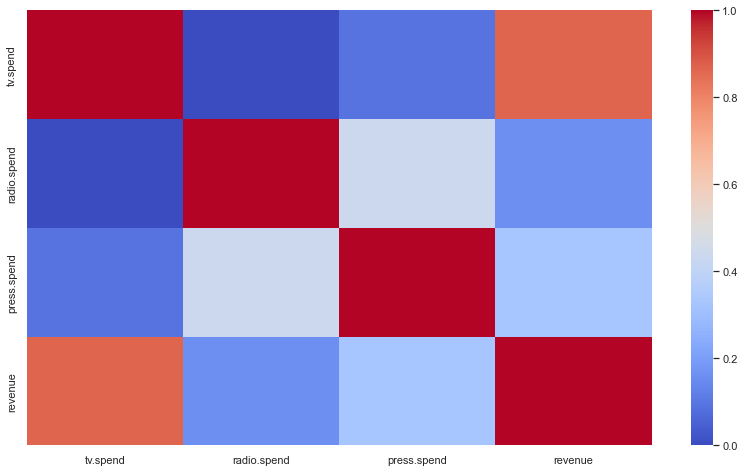

In [11]:
#visualizing the correlation between variables

sns.set(rc={'figure.figsize':(14,8)})

sns.heatmap(df.drop('time.index', axis = 1).corr(), cmap = 'coolwarm')

## 1.2 Adding temperature to represent seasonality

In [12]:
#loading temperature as an external dataset

temperature = pd.read_excel('External/data_meteo_france.xlsx')

In [13]:
#reducing the temperature dataset to the same size

temperature = temperature[:156].copy()

In [14]:
#recreating the time.index variable which will be later used when merging with the main dataset

temperature.reset_index(inplace = True)
temperature['index'] = temperature['index']+53

Text(0.5, 1.0, 'Average weekly temperature in the 5 most populous cities of France')

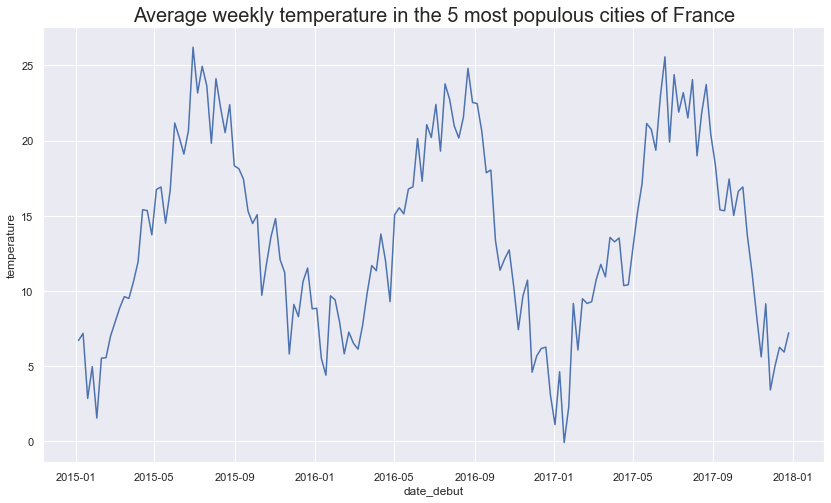

In [15]:
#plotting the temperature

sns.lineplot(x = 'date_debut', y = 'temperature', data = temperature).set_title('Average weekly temperature in the 5 most populous cities of France', size=  20)

In [16]:
#merging the temperature data with the main dataset

df = pd.merge(df, temperature[['index','temperature']], left_on = 'time.index', right_on = 'index').drop('index', axis = 1)

In [17]:
df.columns

Index(['time.index', 'tv.spend', 'radio.spend', 'press.spend', 'revenue',
       'temperature'],
      dtype='object')

In [18]:
#we shall take all of the explainer variables into account

X = df[['tv.spend', 'radio.spend','press.spend', 'temperature']]

y = df['revenue']

# 2. Applying the machine learning algorithms to the data

##  2.1 Linear model

In [19]:
#initializing the linear regression model and fitting it to the whole dataset

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.8599088126789282

### 2.1.1 Linear Score

In [20]:
#preparing the test/train data

X_train = X[:103].copy()
y_train = y[:103].copy()

X_test = X[103:].copy()
y_test = y[103:].copy()

In [21]:
#fitting the linear regression model to the train/test data

reg_score = LinearRegression().fit(X_train, y_train)

linear_preds = reg_score.predict(X_test)

In [22]:
#calculating the scores

linear_r2 = metrics.r2_score(y_test, linear_preds)
linear_mae = metrics.mean_absolute_error(y_test, linear_preds)
linear_rmse = np.sqrt(metrics.mean_squared_error(y_test, linear_preds))
linear_mape = metrics.mean_absolute_percentage_error(y_test, linear_preds)

In [23]:
results_consolidated = pd.DataFrame(data = [linear_r2, linear_mae, linear_rmse, linear_mape], index = ['R²', 'MAE', 'RMSE', 'MAPE'], columns = ['Linear Regression'])
results_consolidated

Linear Regression
R²             0.845556
MAE       562038.688868
RMSE      671612.497780
MAPE           0.141480

In [24]:
linear_preds_compare = pd.DataFrame()

linear_preds_compare['true'] = y_test
linear_preds_compare['linear_preds'] = linear_preds

In [25]:
fig = px.line(linear_preds_compare.reset_index(), x="index", y = linear_preds_compare.columns, title='Linear Predictions vs Target Variable')

fig.show()

### 2.1.2 Linear Regression - Calculating coefficients

In [26]:
#extracting the coefficients of the regression

coeffs = dict(zip(X.columns, reg.coef_))

In [27]:
#adding the base coefficient of the model

coeffs['base'] = reg.intercept_

In [28]:
coeffs

{'tv.spend': 11.655110960614113,
 'radio.spend': 1.8804515266544684,
 'press.spend': 32.096042652732365,
 'temperature': -76748.45768829927,
 'base': 3902057.709350913}

Text(0.5, 1.0, 'residuals')

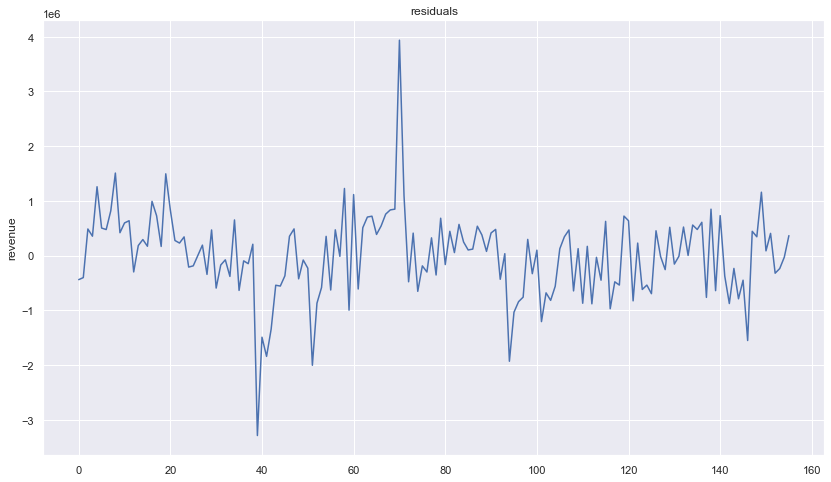

In [29]:
#plotting the residuals

preds = reg.predict(X)
sns.lineplot(x = range(0, len(preds)), y = preds - y).set_title('residuals')

In [30]:
#constructing the contributions dataset

contrib = X * reg.coef_

contrib['base'] = reg.intercept_

contrib['y'] = y

contrib = contrib[['base',"tv.spend", 'radio.spend', 'press.spend', 'temperature','y']].copy()

In [31]:
contrib.to_excel('contribs.xlsx')

In [32]:
fig = px.line(contrib.reset_index(), x="index", y= ['tv.spend', 'radio.spend', 'press.spend', 'temperature'], title='Contributions')

fig

Text(0.5, 1.0, '')

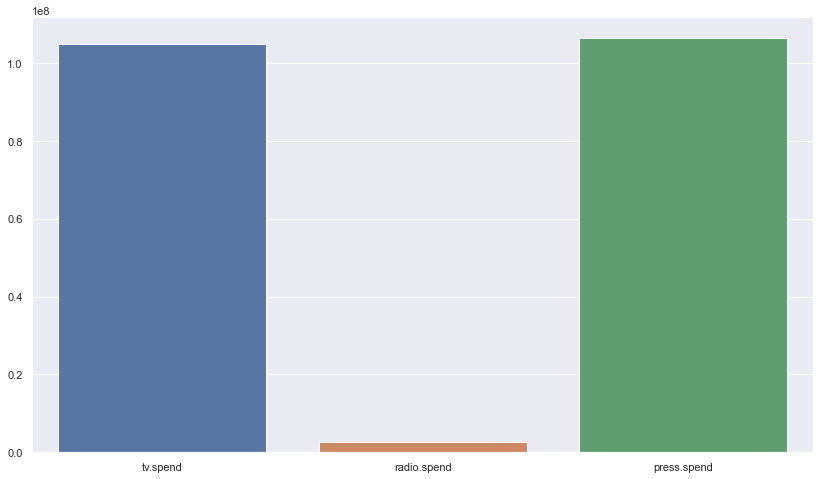

In [33]:
sns.barplot(x =  ["tv.spend", 'radio.spend', 'press.spend'], y = contrib[["tv.spend", 'radio.spend', 'press.spend']].sum()).set_title('')

In [34]:
import matplotlib.pyplot as plt

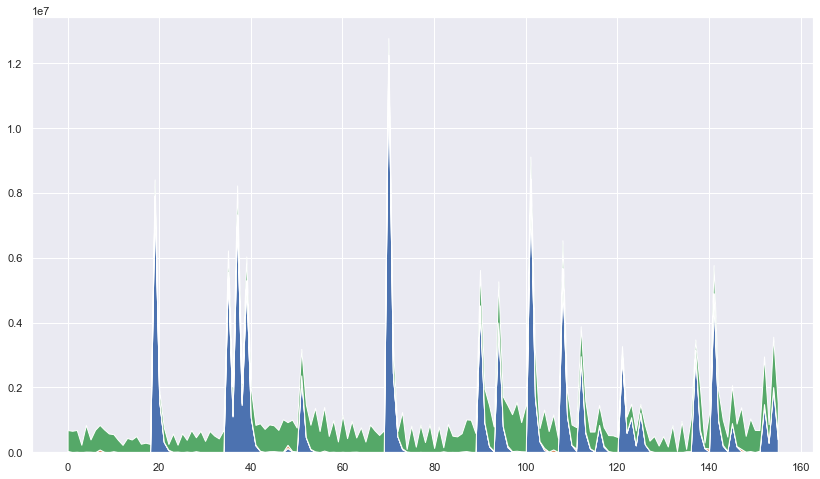

In [35]:
plt.stackplot(contrib.reset_index()['index'], contrib['tv.spend'],contrib['radio.spend'],contrib['press.spend'])

### 2.1.3 Linear Regression - calculating the ROI

In [36]:
contrib.sum()[['tv.spend','radio.spend', 'press.spend']].values

array([1.04796849e+08, 2.74666055e+06, 1.06370387e+08])

In [37]:
df_o.sum()[['tv.spend','radio.spend', 'press.spend']].values

# .iloc[["tv.spend",'rado.spend','press.spend', 'search.spend']]

array([7200000., 1250000., 3150000.])

In [38]:
roi = pd.DataFrame(columns = ['expenditures','contributions'],index = ['tv', 'radio','press'])

In [39]:
roi['expenditures'] = df_o.sum()[['tv.spend','radio.spend', 'press.spend']].values

In [40]:
roi['contributions'] = contrib.sum()[['tv.spend','radio.spend', 'press.spend']].values

In [41]:
roi['roi'] = roi['contributions'] / roi['expenditures']

In [42]:
coeffs

{'tv.spend': 11.655110960614113,
 'radio.spend': 1.8804515266544684,
 'press.spend': 32.096042652732365,
 'temperature': -76748.45768829927,
 'base': 3902057.709350913}

In [43]:
roi

expenditures  contributions        roi
tv        7200000.0   1.047968e+08  14.555118
radio     1250000.0   2.746661e+06   2.197328
press     3150000.0   1.063704e+08  33.768377

<AxesSubplot:xlabel='index', ylabel='roi'>

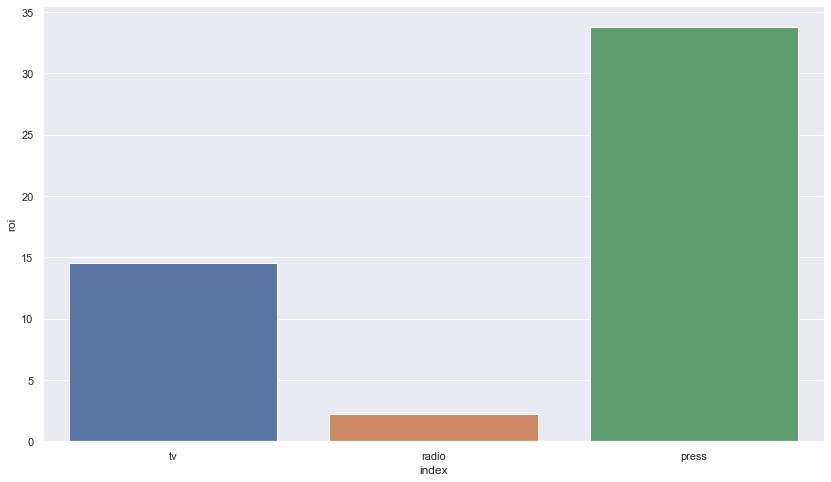

In [44]:
sns.barplot(x = 'index', y = 'roi', data = roi.reset_index())

In [45]:
px.bar(data_frame = roi.head(3).reset_index().sort_values(by = 'expenditures', ascending = False), x = 'index', y = "contributions", color = 'index', title= "Total Contribution per Traditional Media Channel")

In [46]:
px.bar(data_frame = roi.head(3).reset_index().sort_values(by = 'expenditures', ascending = False), x = 'index', y = "expenditures", color = 'index', title= "Total Budget per Traditional Media Channel")

In [47]:
px.bar(data_frame = roi.head(3).reset_index().sort_values(by = 'expenditures', ascending = False), x = 'index', y = "roi", color = 'index', title= "ROI per Traditional Media Channel")

---

## 2.2 XGBoost

In [48]:
from xgboost import XGBRegressor

from xgboost import plot_importance

### 2.2.1 XGBoost Score

In [49]:
#fitting the model to the train/test data

xgboost_score = XGBRegressor().fit(X_train, y_train)

xgboost_preds = xgboost_score.predict(X_test)

In [50]:
#calculating the scores

xgboost_r2 = metrics.r2_score(y_test, xgboost_preds)
xgboost_mae = metrics.mean_absolute_error(y_test, xgboost_preds)
xgboost_rmse = np.sqrt(metrics.mean_squared_error(y_test, xgboost_preds))
xgboost_mape = metrics.mean_absolute_percentage_error(y_test, xgboost_preds)

In [51]:
results_consolidated['XGBoost'] = [xgboost_r2, xgboost_mae, xgboost_rmse, xgboost_mape]

In [52]:
results_consolidated

Linear Regression        XGBoost
R²             0.845556       0.818832
MAE       562038.688868  588319.391509
RMSE      671612.497780  727399.977808
MAPE           0.141480       0.152928

In [53]:
xgboost_preds_compare = pd.DataFrame()

xgboost_preds_compare['true'] = y_test
xgboost_preds_compare['xgboost_preds'] = xgboost_preds

In [54]:
xgboost_preds_compare.head()

true  xgboost_preds
103  5232912      5519727.0
104  5694696      4850907.5
105  4077528      4665215.5
106  4731544      4339021.0
107  3711672      4384813.5

In [55]:
fig = px.line(xgboost_preds_compare.reset_index(), x="index", y = xgboost_preds_compare.columns, title='XGBoost Predictions vs Target Variable')

fig.show()

### 2.2.2 Interpreting the XGBoost results

In [56]:
model = XGBRegressor()

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:>

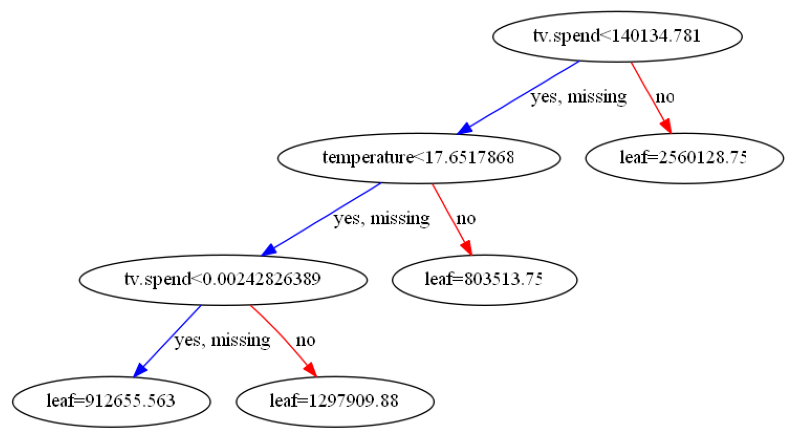

In [57]:
plot_tree(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

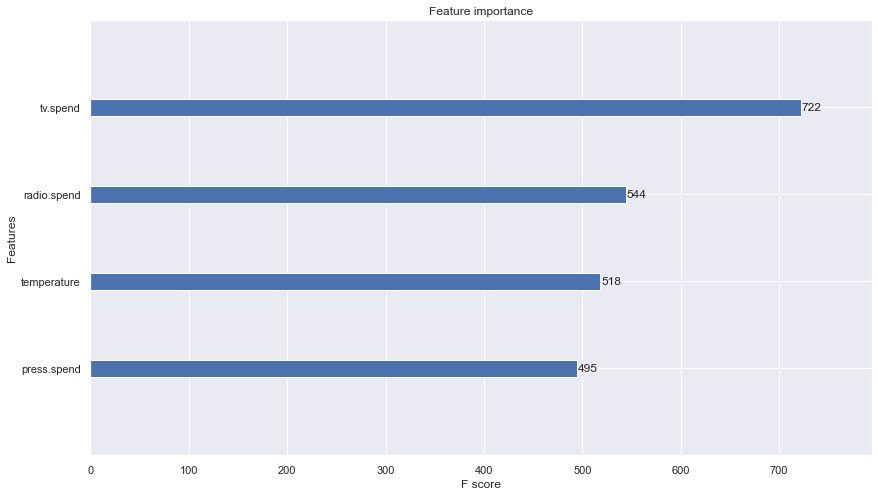

In [58]:
plot_importance(model)

In [59]:
model.score(X, y)

0.9999999268018815

In [60]:
preds = model.predict(X)

In [61]:
import shap

In [62]:
explainer =  shap.TreeExplainer(model)

In [63]:
shap_values = shap.TreeExplainer(model).shap_values(X)


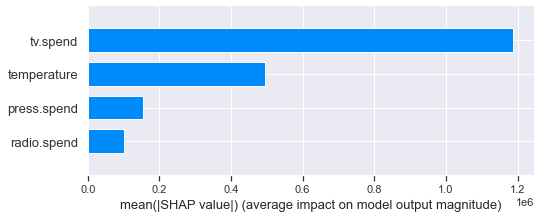

In [64]:
shap.summary_plot(shap_values, X, plot_type="bar")

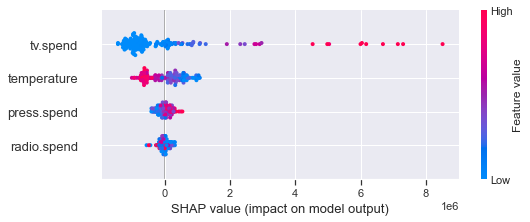

In [65]:
shap.summary_plot(shap_values, X)

In [66]:
shap.initjs()

In [67]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [68]:
shap.force_plot(explainer.expected_value, shap_values, X, plot_cmap="DrDb")

In [69]:
shap_values.sum(axis = 0)

array([  658754.44, -1684777.8 , -1423851.8 ,  2449866.8 ], dtype=float32)